In [1]:


%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import mdshare
import pyemma
from pyemma.util.contexts import settings



/home/dhiman/miniconda3/envs/pyemma/lib/python3.7/site-packages/mdshare/repository.py:53: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = load(fh)
/home/dhiman/miniconda3/envs/pyemma/lib/python3.7/site-packages/pyemma/util/log.py:64: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  D = yaml.load(f2)
/home/dhiman/miniconda3/envs/pyemma/lib/python3.7/site-packages/pyemma/__init__.py:92: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.6, you have 2.5.5.
  .format(latest=latest, current=current), category=UserWarning)


In [2]:
pdb = '3base_traj_1.pdb'
files = ['3base_traj_%i.dcd'%d for d in range(1,46)]
print(files)

['3base_traj_1.dcd', '3base_traj_2.dcd', '3base_traj_3.dcd', '3base_traj_4.dcd', '3base_traj_5.dcd', '3base_traj_6.dcd', '3base_traj_7.dcd', '3base_traj_8.dcd', '3base_traj_9.dcd', '3base_traj_10.dcd', '3base_traj_11.dcd', '3base_traj_12.dcd', '3base_traj_13.dcd', '3base_traj_14.dcd', '3base_traj_15.dcd', '3base_traj_16.dcd', '3base_traj_17.dcd', '3base_traj_18.dcd', '3base_traj_19.dcd', '3base_traj_20.dcd', '3base_traj_21.dcd', '3base_traj_22.dcd', '3base_traj_23.dcd', '3base_traj_24.dcd', '3base_traj_25.dcd', '3base_traj_26.dcd', '3base_traj_27.dcd', '3base_traj_28.dcd', '3base_traj_29.dcd', '3base_traj_30.dcd', '3base_traj_31.dcd', '3base_traj_32.dcd', '3base_traj_33.dcd', '3base_traj_34.dcd', '3base_traj_35.dcd', '3base_traj_36.dcd', '3base_traj_37.dcd', '3base_traj_38.dcd', '3base_traj_39.dcd', '3base_traj_40.dcd', '3base_traj_41.dcd', '3base_traj_42.dcd', '3base_traj_43.dcd', '3base_traj_44.dcd', '3base_traj_45.dcd']


In [3]:
#dihedral angles
diAT = [[80,81,84,85],[81,84,85,86],
                   [84,85,86,87],[85,86,87,88],
                   [86,87,88,99],[87,88,99,100],
                   [88,99,100,86],[99,100,86,85],
                   [85,86,100,101],[86,100,101,102],
                   [100,101,102,105],[87,88,89,96],      #upto here is A base
                   [19,20,23,24],[20,23,24,25],[23,24,25,26],[24,25,26,27],[25,26,27,37],
                   [26,27,37,38],[27,37,38,25],[37,38,25,24],[24,25,38,39],[25,38,39,40],
                   [38,39,40,43]] #upto here is T base
#Hydrogen bond distances
Hbond = [[32,91],[34,98],[32,93]]
feat = pyemma.coordinates.featurizer(pdb)
feat.add_dihedrals(diAT,cossin=False)
feat.add_distances(Hbond)
data = pyemma.coordinates.load(files, features=feat)

In [4]:
def score_cv(data, dim, lag, number_of_splits=10, validation_fraction=0.5):
    """Compute a cross-validated VAMP2 score.

    We randomly split the list of independent trajectories into
    a training and a validation set, compute the VAMP2 score,
    and repeat this process several times.

    Parameters
    ----------
    data : list of numpy.ndarrays
        The input data.
    dim : int
        Number of processes to score; equivalent to the dimension
        after projecting the data with VAMP2.
    lag : int
        Lag time for the VAMP2 scoring.
    number_of_splits : int, optional, default=10
        How often do we repeat the splitting and score calculation.
    validation_fraction : int, optional, default=0.5
        Fraction of trajectories which should go into the validation
        set during a split.
    """
    # we temporarily suppress very short-lived progress bars
    with pyemma.util.contexts.settings(show_progress_bars=False):
        nval = int(len(data) * validation_fraction)
        scores = np.zeros(number_of_splits)
        for n in range(number_of_splits):
            ival = np.random.choice(len(data), size=nval, replace=False)
            vamp = pyemma.coordinates.vamp(
                [d for i, d in enumerate(data) if i not in ival], lag=lag, dim=dim)
            scores[n] = vamp.score([d for i, d in enumerate(data) if i in ival])
    return scores




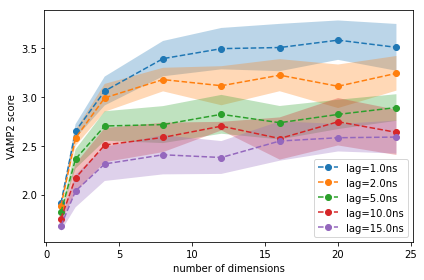

In [5]:
lags = [100, 200, 500, 1000, 1500]
dims = [i for i in [1, 2, 4, 8, 12, 16, 20, 24]]
#dims = [1]

fig, ax = plt.subplots()
for i, lag in enumerate(lags):
    scores_ = np.array([score_cv(data, dim, lag)
                        for dim in dims])
    scores = np.mean(scores_, axis=1)
    errors = np.std(scores_, axis=1, ddof=1)
    color = 'C{}'.format(i)
    ax.fill_between(dims, scores - errors, scores + errors, alpha=0.3, facecolor=color)
    ax.plot(dims, scores, '--o', color=color, label='lag={:.1f}ns'.format(lag * 0.01))
ax.legend()
ax.set_xlabel('number of dimensions')
ax.set_ylabel('VAMP2 score')
fig.tight_layout()

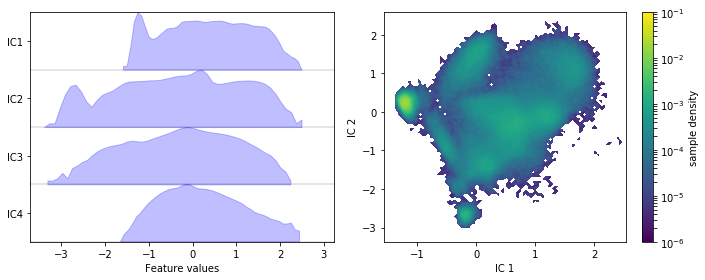

In [4]:
tica = pyemma.coordinates.tica(data, lag=200)
tica_output = tica.get_output()
tica_concatenated = np.concatenate(tica_output)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(
    tica_concatenated[:, :4],
    ax=axes[0],
    feature_labels=['IC1', 'IC2', 'IC3', 'IC4'],
    ylog=True, ignore_dim_warning=True)
pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], logscale=True)
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
fig.tight_layout()

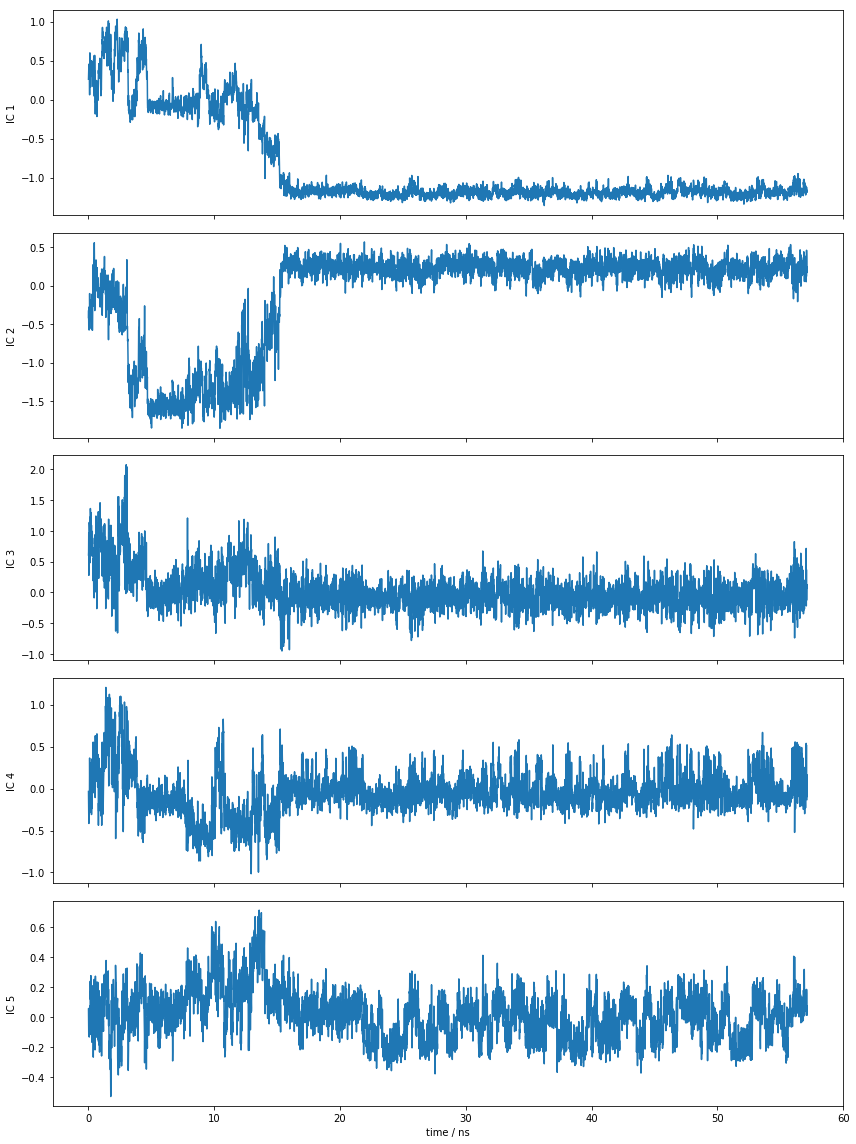

In [6]:
fig, axes = plt.subplots(5, 1, figsize=(12,16), sharex=True)
x = 0.01 * np.arange(tica_output[0].shape[0])
for i, (ax, tic) in enumerate(zip(axes.flat, tica_output[0].T)):
    ax.plot(x, tic)
    ax.set_ylabel('IC {}'.format(i + 1))
axes[-1].set_xlabel('time / ns')
fig.tight_layout()
plt.savefig('TICA-trajectory.pdf')

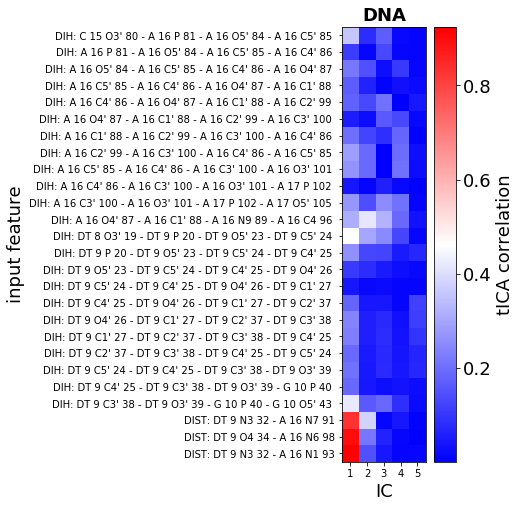

In [7]:
fig, ax = plt.subplots(figsize=(3, 8))
i = ax.imshow(abs(tica.feature_TIC_correlation), cmap='bwr')

ax.set_xticks(range(tica.dimension()))
ax.set_xticklabels(range(1,tica.dimension()+1))
ax.set_xlabel('IC',fontsize=18)

ax.set_yticks(range(feat.dimension()))
ax.set_yticklabels(feat.describe())
ax.set_ylabel('input feature',fontsize=18)

cbar=fig.colorbar(i);
cbar.ax.tick_params(labelsize=18)
cbar.ax.set_ylabel('tICA correlation',fontsize=18)
plt.title('DNA',fontsize=18,fontweight='bold')
plt.savefig('tica.pdf',bbox_inches='tight')
#print(tica.feature_TIC_correlation)

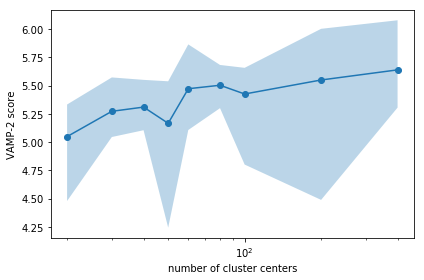

In [9]:
n_clustercenters = [20, 30, 40, 50, 60, 80, 100, 200, 400]

scores = np.zeros((len(n_clustercenters), 10))
for n, k in enumerate(n_clustercenters):
    for m in range(10):
        with pyemma.util.contexts.settings(show_progress_bars=False):
            _cl = pyemma.coordinates.cluster_kmeans(
                tica_output, k=k, max_iter=50, stride=50)
            _msm = pyemma.msm.estimate_markov_model(_cl.dtrajs, 1000)
            scores[n, m] = _msm.score_cv(
                _cl.dtrajs, n=1, score_method='VAMP2', score_k=min(10, k))

fig, ax = plt.subplots()
lower, upper = pyemma.util.statistics.confidence_interval(scores.T.tolist(), conf=0.9)
ax.fill_between(n_clustercenters, lower, upper, alpha=0.3)
ax.plot(n_clustercenters, np.mean(scores, axis=1), '-o')
ax.semilogx()
ax.set_xlabel('number of cluster centers')
ax.set_ylabel('VAMP-2 score')
fig.tight_layout()

In [11]:
print(scores)

[[3.12783569 3.62229355 3.04665015 3.34166003 2.84970031]
 [4.95746609 4.42723884 4.71739946 5.04800494 4.61280562]
 [4.67511768 5.32406505 3.82196508 4.77928745 5.39123452]
 [5.17288834 5.6665039  5.71427587 5.21986375 5.68040053]
 [5.33588416 5.54828058 5.21911275 5.56230123 4.41260578]
 [5.40006795 5.66258736 4.61175794 5.26594255 5.68173223]
 [4.4343096  5.46338198 4.38626156 4.86946214 3.3869931 ]
 [4.94048012 5.85364369 4.54554745 4.50222799 5.11477029]]


In [8]:
cluster = pyemma.coordinates.cluster_kmeans(
    tica_output, k=400, max_iter=50, stride=1)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)

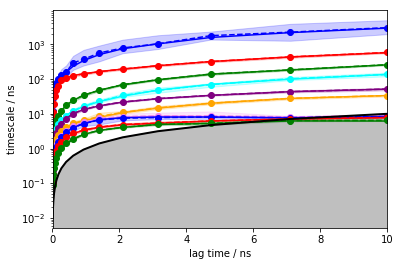

In [9]:

its = pyemma.msm.its(cluster.dtrajs, lags=1000, nits=10, errors='bayes')
pyemma.plots.plot_implied_timescales(its, units='ns', dt=0.01, ylog=True)
plt.savefig('Implied-timescales.pdf')

In [10]:
msm = pyemma.msm.estimate_markov_model(cluster.dtrajs, lag=200, dt_traj='0.01 ns')


In [71]:
msm

MaximumLikelihoodMSM(connectivity='largest', count_mode='sliding',
           dt_traj='0.01 ns', lag=200, maxerr=1e-08, maxiter=1000000,
           mincount_connectivity='1/n', reversible=True, score_k=10,
           score_method='VAMP2', sparse=False, statdist_constraint=None)

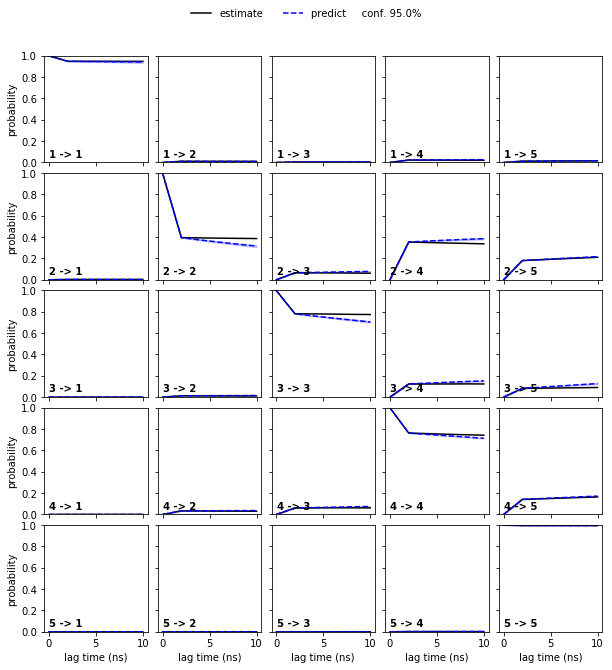

In [24]:
nstates = 5
cktest = msm.cktest(nstates, mlags=6)
pyemma.plots.plot_cktest(cktest, dt=0.01, units='ns');

plt.savefig('CKTest.pdf')

In [11]:
print('fraction of states used = {:.2f}'.format(msm.active_state_fraction))
print('fraction of counts used = {:.2f}'.format(msm.active_count_fraction))

fraction of states used = 1.00
fraction of counts used = 1.00


In [12]:
#save the data in a file so that we can call it back
cluster.save('dihedral.pyemma',model_name='dihedral-cluster',overwrite=True)
msm.save('dihedral.pyemma',model_name='dihedral-msm',overwrite=True)
tica.save('dihedral.pyemma',model_name='dihedral-tica',overwrite=True)

09-08-19 17:44:45 pyemma._base.serialization.h5file INFO     overwriting model "dihedral-cluster" in file dihedral.pyemma
09-08-19 17:44:45 pyemma._base.serialization.h5file INFO     overwriting model "dihedral-msm" in file dihedral.pyemma
09-08-19 17:44:45 pyemma._base.serialization.h5file INFO     overwriting model "dihedral-tica" in file dihedral.pyemma


/home/dhiman/miniconda3/envs/pyemma/lib/python3.7/site-packages/pyemma/_base/serialization/pickle_extensions.py:52: UserWarning: BLOSC compression filter unavailable. Your resulting file may be large and not optimal to process.
  warnings.warn('BLOSC compression filter unavailable. '


In [5]:
#import saved data
msm = pyemma.load('dihedral.pyemma',model_name='dihedral-msm')
cluster = pyemma.load('dihedral.pyemma',model_name='dihedral-cluster')
#tica = pyemma.load('dihedral.pyemma',model_name='dihedral-tica')
#tica_output = tica.get_output()
#tica_concatenated = np.concatenate(tica_output)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)

/home/dhiman/miniconda3/envs/pyemma/lib/python3.7/site-packages/pyemma/_base/serialization/pickle_extensions.py:52: UserWarning: BLOSC compression filter unavailable. Your resulting file may be large and not optimal to process.
  warnings.warn('BLOSC compression filter unavailable. '


In [3]:
tica

NameError: name 'tica' is not defined

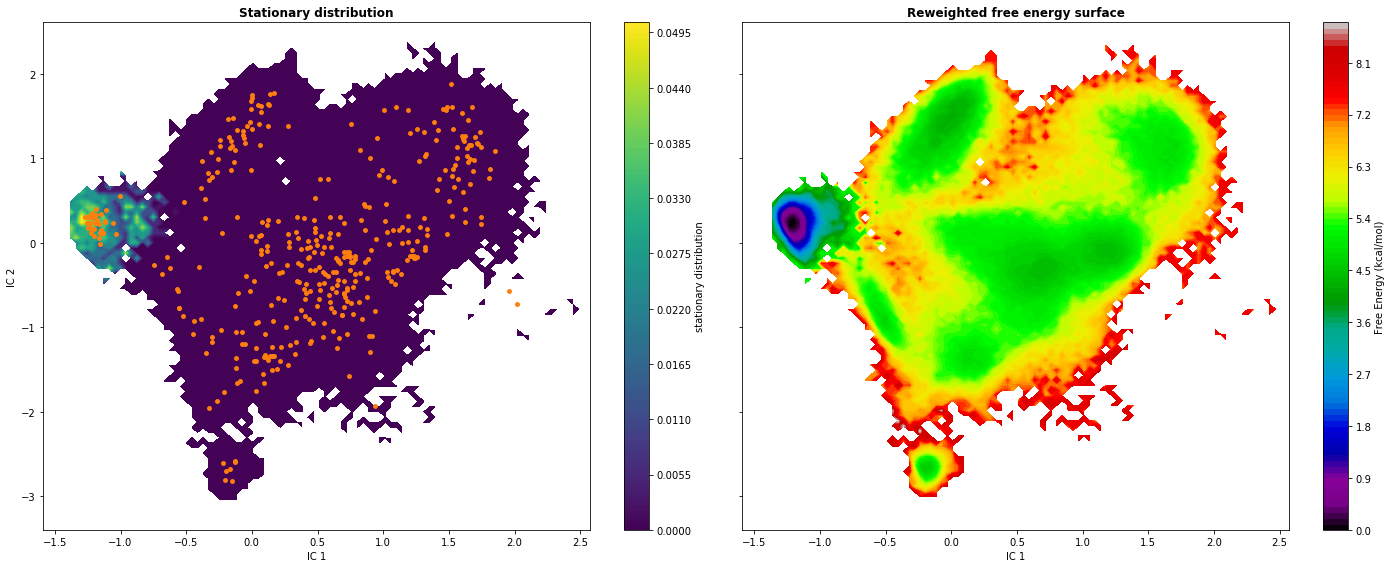

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharex=True, sharey=True)
pyemma.plots.plot_contour(
    *tica_concatenated[:, :2].T,
    msm.pi[dtrajs_concatenated],
    ax=axes[0],
    mask=True,
    cbar_label='stationary distribution')
pyemma.plots.plot_free_energy(
    *tica_concatenated[:, :2].T,
    weights=np.concatenate(msm.trajectory_weights()),
    ax=axes[1],
    legacy=False, kT=0.6, cbar_label='Free Energy (kcal/mol)')
for ax in axes.flat:
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
axes[0].set_title('Stationary distribution', fontweight='bold')
axes[1].set_title('Reweighted free energy surface', fontweight='bold')
axes[0].scatter(*cluster.clustercenters[:,:2].T, s = 15, c='C1')
fig.tight_layout()
#plt.savefig('Free-Energy.pdf')


The first eigenvector is one: True (min=0.9999999999994389, max=1.0000000000000682)


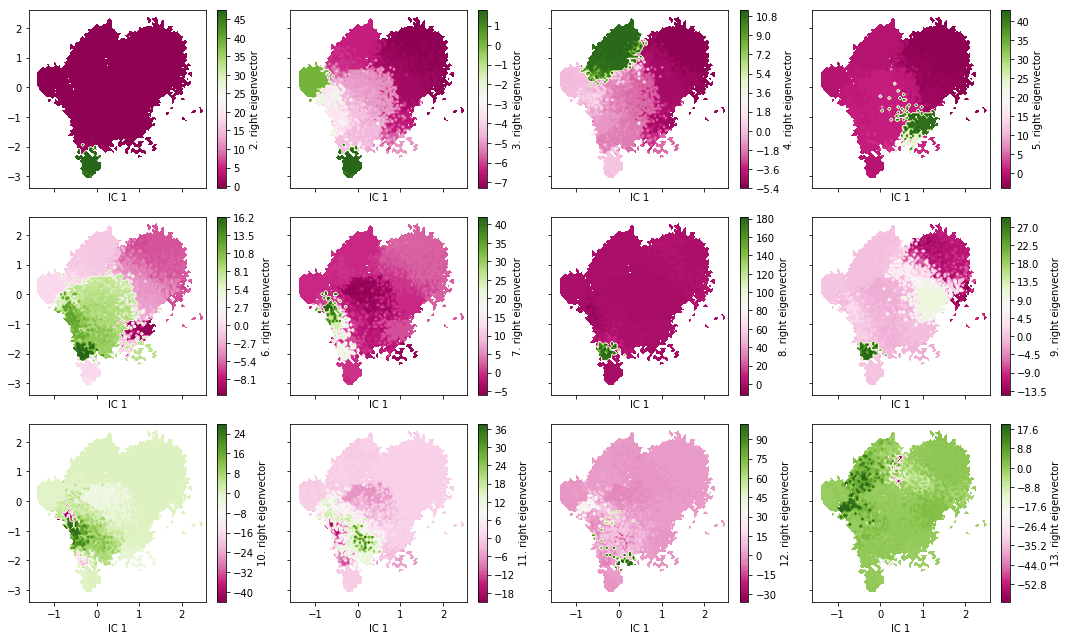

In [14]:


eigvec = msm.eigenvectors_right()
print('The first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

fig, axes = plt.subplots(3, 4, figsize=(15, 9), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *tica_concatenated[:, :2].T,
        eigvec[dtrajs_concatenated, i + 1],
        ax=ax,
        cmap='PiYG',
        cbar_label='{}. right eigenvector'.format(i + 2),
        mask=True)
    ax.set_xlabel('IC 1')
#axes[0].set_ylabel('IC 2')
fig.tight_layout()



In [3]:
nstates = 5
msm.pcca(nstates)

PCCA(P=array([[0.01989, 0.     , ..., 0.     , 0.02933],
       [0.     , 0.04722, ..., 0.     , 0.     ],
       ...,
       [0.     , 0.     , ..., 0.03187, 0.     ],
       [0.01907, 0.     , ..., 0.     , 0.02727]]),
   m=5)

In [134]:
#save the data in a file so that we can call it back
cluster.save('dihedral.pyemma',model_name='dihedral-cluster',overwrite=True)
msm.save('dihedral.pyemma',model_name='dihedral-msm',overwrite=True)
tica.save('dihedral.pyemma',model_name='dihedral-tica',overwrite=True)

/home/dhiman/miniconda3/envs/pyemma/lib/python3.7/site-packages/pyemma/_base/serialization/pickle_extensions.py:52: UserWarning: BLOSC compression filter unavailable. Your resulting file may be large and not optimal to process.
  warnings.warn('BLOSC compression filter unavailable. '


In [2]:
#import saved data
msm = pyemma.load('dihedral.pyemma',model_name='dihedral-msm')
cluster = pyemma.load('dihedral.pyemma',model_name='dihedral-cluster')
#tica = pyemma.load('dihedral.pyemma',model_name='dihedral-tica')
#tica_output = tica.get_output()
#tica_concatenated = np.concatenate(tica_output)

/home/dhiman/miniconda3/envs/pyemma/lib/python3.7/site-packages/pyemma/_base/serialization/pickle_extensions.py:52: UserWarning: BLOSC compression filter unavailable. Your resulting file may be large and not optimal to process.
  warnings.warn('BLOSC compression filter unavailable. '


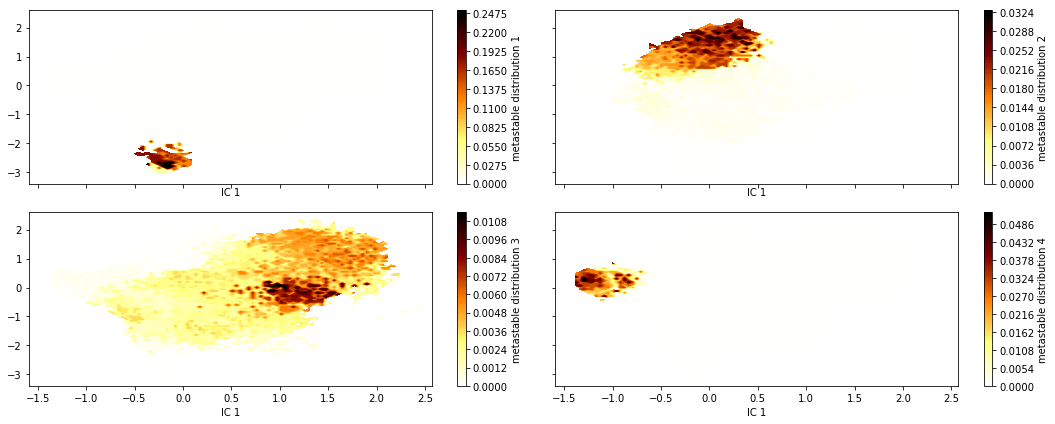

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(15, 6), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *tica_concatenated[:, :2].T,
        msm.metastable_distributions[i][dtrajs_concatenated],
        ax=ax,
        cmap='afmhot_r',
        mask=True,
        cbar_label='metastable distribution {}'.format(i + 1))
    ax.set_xlabel('IC 1')
#a.set_ylabel('IC 2')
fig.tight_layout()

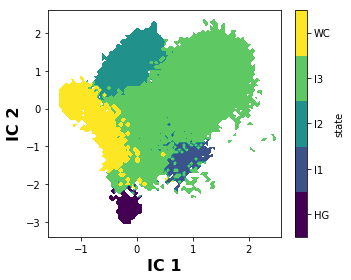

In [8]:
metastable_traj = msm.metastable_assignments[dtrajs_concatenated]


tic1 = 1
tic2 = 2

fig, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, ((tic1-1),(tic2-1))].T, metastable_traj, ax=ax)
ax.set_xlabel('IC %d'%tic1,fontsize=16,fontweight='bold')
ax.set_ylabel('IC %d'%tic2,fontsize=16,fontweight='bold')
misc['cbar'].set_ticklabels(['HG','I1','I2','I3','WC'])
fig.tight_layout()
plt.savefig('states.pdf')

NameError: name 'inverse_mfpt' is not defined

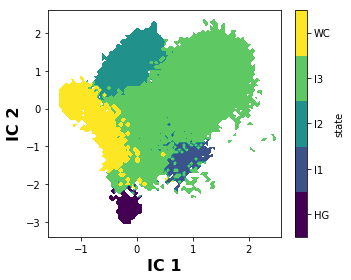

In [13]:
start, final = 0,4
A = msm.metastable_sets[start]
B = msm.metastable_sets[final]
flux = pyemma.msm.tpt(msm, A, B)

cg, cgflux = flux.coarse_grain(msm.metastable_sets)

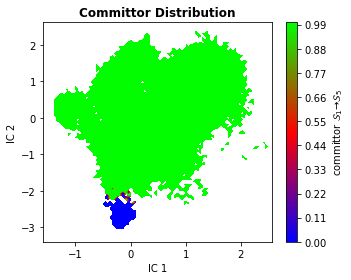

In [14]:
fig, ax = plt.subplots(figsize=(5, 4))

tic1 = 1
tic2 = 2

pyemma.plots.plot_contour(
    *tica_concatenated[:, ((tic1-1),(tic2-1))].T,
    flux.committor[dtrajs_concatenated],
    cmap='brg',
    ax=ax,
    mask=True,
    cbar_label=r'committor $\mathcal{S}_{%d} \to \mathcal{S}_%d$' % (
        start + 1, final + 1))
ax.set_xlabel('IC %d'%tic1)
ax.set_ylabel('IC %d'%tic2)
ax.set_title('Committor Distribution', fontweight='bold')
fig.tight_layout()
#plt.savefig('committor.pdf')

In [84]:
a = np.sort(flux.committor)
a

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.98131818, 0.99206411, 0.9936691 , 0.99472962,
       0.99594925, 0.99600832, 0.99601079, 0.99605688, 0.99690997,
       0.99691372, 0.99698502, 0.99703717, 0.99706861, 0.99707495,
       0.99708731, 0.99711409, 0.9971144 , 0.99720667, 0.99736682,
       0.99737461, 0.99737943, 0.99740231, 0.99742776, 0.99743016,
       0.99743191, 0.99743939, 0.9974418 , 0.99744826, 0.99745426,
       0.99745524, 0.9974584 , 0.99745936, 0.99746313, 0.99746358,
       0.99746521, 0.9974654 , 0.99746677, 0.99746805, 0.99746855,
       0.99747029, 0.99747303, 0.99747529, 0.99748192, 0.99748274,
       0.99748316, 0.9974844 , 0.99748472, 0.99748503, 0.99748544,
       0.99748755, 0.99748916, 0.99749073, 0.9974958 , 0.99750062,
       0.99750411, 0.99750448, 0.99750567, 0.99750973, 0.99751132,
       0.99751142, 0.99751373, 0.99751417, 0.99751445, 0.99751559,
       0.99751673, 0.9975186 , 0.99751887, 0.99751996, 0.99752

In [15]:
from itertools import product
#nstates=50

mfpt = np.zeros((nstates, nstates))
for i, j in product(range(nstates), repeat=2):
    mfpt[i, j] = msm.mfpt(
        msm.metastable_sets[i],
        msm.metastable_sets[j])

from pandas import DataFrame
print('MFPT / ns:')
DataFrame(np.round(mfpt, decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1))

MFPT / ns:


,1,2,3,4,5
1,0.00,48374.01,11421.96,713.94,814.12
2,1525535.70,0.00,10300.17,294.91,146.23
3,1527728.94,49459.16,0.00,1952.30,149.02
4,1525527.71,47262.30,10114.11,0.00,131.54
5,1532088.70,54253.07,15068.37,6468.81,0.00


[[0.00000000e+00 2.06722590e-05 8.75506478e-05 1.40068520e-03
  1.22831775e-03]
 [6.55507439e-07 0.00000000e+00 9.70857926e-05 3.39085565e-03
  6.83872674e-03]
 [6.54566380e-07 2.02187023e-05 0.00000000e+00 5.12216140e-04
  6.71071174e-03]
 [6.55510870e-07 2.11585126e-05 9.88717626e-05 0.00000000e+00
  7.60249916e-03]
 [6.52703724e-07 1.84321355e-05 6.63641776e-05 1.54587899e-04
  0.00000000e+00]]


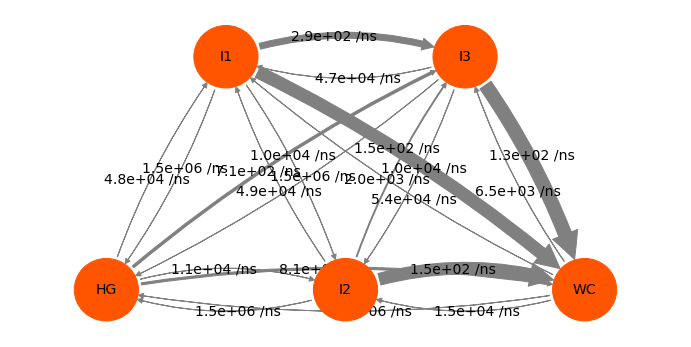

In [8]:
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = msm.mfpt(
            msm.metastable_sets[i],
            msm.metastable_sets[j])

inverse_mfpt = np.zeros_like(mfpt)
nz = mfpt.nonzero()
inverse_mfpt[nz] = 1.0 / mfpt[nz]

print(inverse_mfpt)

pyemma.plots.plot_network(
    inverse_mfpt,
    pos=np.asarray([[0, 0], [2, 4], [4, 0], [6, 4], [8,0]]),
    #coarse_state_centers,
    arrow_label_format='%.1e /ns',
    arrow_labels=mfpt,
    arrow_scale=3.0,
    state_labels=['HG','I1','I2','I3','WC'],
    size=14);
#plt.savefig('network.pdf')

In [17]:
highest_membership = msm.metastable_distributions.argmax(1)
coarse_state_centers = cluster.clustercenters[msm.active_set[highest_membership]]

(-3.5, 2.5)

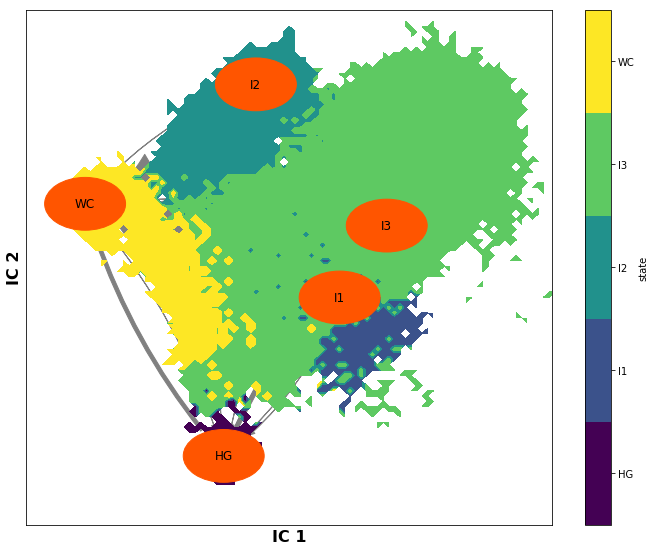

In [30]:
metastable_traj = msm.metastable_assignments[dtrajs_concatenated]


tic1 = 1
tic2 = 2

fig, ax = plt.subplots(figsize=(10, 8))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, ((tic1-1),(tic2-1))].T, metastable_traj, ax=ax)
ax.set_xlabel('IC %d'%tic1,fontsize=16,fontweight='bold')
ax.set_ylabel('IC %d'%tic2,fontsize=16,fontweight='bold')
misc['cbar'].set_ticklabels(['HG','I1','I2','I3','WC'])
fig.tight_layout()

pyemma.plots.plot_network(
    inverse_mfpt,
    pos=coarse_state_centers,
    figpadding=0.2,
    #arrow_label_format='%.1f ps',
    arrow_labels=None,
    size=12,
    show_frame=True,
    arrow_scale=5.0,
    state_labels=['HG','I1','I2','I3','WC'],
    ax=ax)

ax.set_xlim(-1.7, 2.3)
ax.set_ylim(-3.5, 2.5)

In [34]:
pcca_samples = msm.sample_by_distributions(msm.metastable_distributions, 500)
torsions_source = pyemma.coordinates.source(files, features=feat)
pyemma.coordinates.save_trajs(
    torsions_source,
    pcca_samples,
    outfiles=['pcca{}_5states_500samples_tica-2ns.pdb'.format(n + 1)
              for n in range(msm.n_metastable)])

['pcca1_5states_500samples_tica-2ns.pdb',
 'pcca2_5states_500samples_tica-2ns.pdb',
 'pcca3_5states_500samples_tica-2ns.pdb',
 'pcca4_5states_500samples_tica-2ns.pdb',
 'pcca5_5states_500samples_tica-2ns.pdb']

In [108]:
#flux.major_flux(fraction=0.5)
flux.gross_flux.size


6400

In [39]:
paths, path_fluxes = cgflux.pathways(fraction=0.99)
print('percentage       \tpath')
print('-------------------------------------')
for i in range(len(paths)):
    print(np.round(path_fluxes[i] / np.sum(path_fluxes), 3),' \t', paths[i] + 1)

percentage       	path
-------------------------------------
0.918  	 [1 4 5]
0.082  	 [1 4 3 5]


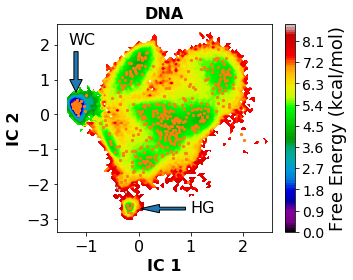

In [32]:
fig, axes = plt.subplots(1, 1, figsize=(5,4), sharex=True, sharey=True)

_, _, misc = pyemma.plots.plot_free_energy(
    *tica_concatenated[:, :2].T,
    weights=np.concatenate(msm.trajectory_weights()),
    ax=axes,
    kT=0.6,
    cbar=True,
    cbar_label='Free Energy (kcal/mol)',
    #cax=fig.colorbar,
    legacy=False)
axes.set_xlabel('IC 1',fontsize=16,fontweight='bold')
axes.set_ylabel('IC 2',fontsize=16,fontweight='bold')
axes.set_xticks([-1,0,1,2])
axes.tick_params(labelsize=16)
misc['cbar'].ax.tick_params(labelsize=14)
misc['cbar'].ax.set_ylabel('Free Energy (kcal/mol)',fontsize=18)
#axes.xticks()
#axes.set_title('Reweighted free energy surface', fontsize=16,fontweight='bold')
axes.scatter(*cluster.clustercenters[:,:2].T, s = 5, c='C1')
plt.arrow(-1.2,1.8,0.0,-0.8,width=0.08)
plt.text(-1.35, 2.0, 'WC',fontsize=16)
plt.arrow(0.9,-2.7, -0.5, 0.0, width=0.08)
plt.text(1.0, -2.8, 'HG',fontsize=16)
plt.title('DNA',weight='bold',fontsize=16)
plt.tight_layout()
plt.savefig('Free-energy.pdf')

HIDDEN MARKOV MODEL BEYOND THIS LINE------------------------------------------------------------------------

In [116]:
hmm = pyemma.msm.estimate_hidden_markov_model(cluster.dtrajs, 4, 500, stride=1)

ValueError: Input matrix is not weakly connected. Therefore it has no unique stationary distribution. Separate disconnected components and handle them separately